# Learning disentangled representations in 'grid-world'

This is a simplified implementation of Flatland (see the flatland notebook). Here, we use our method to learn representations of a 2D periodic gridworld.

## 1. Preamble

In [1]:
import os

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import time
from IPython import display

In [2]:
def mk_dir(export_dir, quite=False):
    if not os.path.exists(export_dir):
            try:
                os.makedirs(export_dir)
                print('created dir: ', export_dir)
            except OSError as exc: # Guard against race condition
                 if exc.errno != exc.errno.EEXIST:
                    raise
            except Exception:
                pass
    else:
        print('dir already exists: ', export_dir)

## 2. Defining objects

### GridWorld environment

First I'll define the GridWorld environment to work in.  The basic idea is that the ball is on a 2-d grid with $n$ discrete points in each dimension.  The available actions step the ball one step in each direction (i.e. there are 4 actions: up/down/left/right).

The observations returned are just an $n \times n$ matrix, with zeros everywhere except where the ball is, which is 1.

In [3]:
class GridWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,dim=5):

        self.dim = dim

        self.action_space = self.action_space(4)
        self.observation_space = self.observation_space(dim**2)
        
        self.reset()
        
    def reset(self):
        self.ball_coordinates = [random.randrange(self.dim), random.randrange(self.dim)]
        self.state = self.get_state()
        return self.get_observation()
    
    def get_state(self, ball_coordinates=None):
        if ball_coordinates is None:
            ball_coordinates=self.ball_coordinates
            
        state = torch.zeros((self.dim,self.dim))
        state[ball_coordinates[0],ball_coordinates[1]] = 1
        
        return state
    
    def get_observation(self):
        return self.state.flatten()
    
    def step(self,action):

        if action == 0:
            self.ball_coordinates[0] = (self.ball_coordinates[0] + 1)%self.dim
        elif action == 1:
            self.ball_coordinates[0] = (self.ball_coordinates[0] - 1)%self.dim
        elif action == 2:
            self.ball_coordinates[1] = (self.ball_coordinates[1] + 1)%self.dim
        elif action == 3:
            self.ball_coordinates[1] = (self.ball_coordinates[1] - 1)%self.dim
        else:
            raise Exception("Invalid action.")

        self.state = self.get_state()

        return self.get_observation()

Now show a few consecutive states from this gridworld

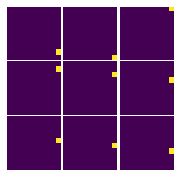

In [4]:
import matplotlib.gridspec as gridspec

env = GridWorld(dim=10)
plt.figure(figsize = (3,3))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.02, hspace=0.02)
plt.grid(None)
state = env.reset()
for i in range(9):
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.imshow(env.state)
    display.display(plt.gcf())
    time.sleep(0.2)
    display.clear_output(wait=True)
    action = random.sample([0,1,2,3],k=1)[0]
    action = 0
    state = env.step(action)
    
plt.savefig("env.png", bbox_inches='tight')

### Latent space

**Encoder/Decoder**

Now we want to learn to represent this environment in some latent space (which we, for now, simply assume to be 4-dimensional).  We will require both an encoder and decoder, and we use simple MLPs.

In [5]:
class Coder(nn.Module):

    def __init__(self, n_in, n_out, n_hid=[32], output_activation=nn.Sigmoid):
        super().__init__()
        
        if type(n_hid) != list:
            n_hid = [n_hid]
        n_layers = [n_in] + n_hid + [n_out]

        self.layers = []
        for i_layer, (n1, n2) in enumerate(zip(n_layers, n_layers[1:])):
            mods = [nn.Linear(n1, n2, bias=True)]
            act_fn = nn.ReLU if i_layer < len(n_layers) - 2 else output_activation
            if act_fn is not None:
                mods.append(act_fn())
            layer = nn.Sequential(*mods)
            self.layers.append(layer)

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nnNorm(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim=dim
        
    def forward(self, x):
        return F.normalize(x, dim=self.dim)
    
class Decoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nn.Sigmoid)
        
class Encoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nnNorm)

In [6]:
encoder = Encoder(n_in=5*5, n_out=4, n_hid=[64])
print(encoder)

decoder = Decoder(n_in=4, n_out=5*5, n_hid=[64])
print(decoder)

Encoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
      (1): nnNorm()
    )
  )
)
Decoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=25, bias=True)
      (1): Sigmoid()
    )
  )
)


Check to make sure dimensions are okay.

In [7]:
x = torch.rand(25)
z = encoder(x)
x_recon = decoder(z)
print("Observable rep (shape = {}) : \n {}".format(x.shape, x))
print("Latent rep (shape = {}, norm = {}) : \n {}".format(z.shape, torch.norm(z), z))
print("Reconstructed Observable rep (shape = {}) : \n {}".format(x_recon.shape, x_recon))

Observable rep (shape = torch.Size([25])) : 
 tensor([0.2722, 0.5423, 0.3341, 0.3865, 0.6722, 0.6125, 0.1992, 0.7558, 0.3218,
        0.5838, 0.3534, 0.7906, 0.0933, 0.2200, 0.0184, 0.4341, 0.2348, 0.9770,
        0.2596, 0.9332, 0.7839, 0.1957, 0.0212, 0.5078, 0.7873])
Latent rep (shape = torch.Size([4]), norm = 1.0) : 
 tensor([-0.1722,  0.8211,  0.3044, -0.4510], grad_fn=<DivBackward0>)
Reconstructed Observable rep (shape = torch.Size([25])) : 
 tensor([0.5955, 0.4950, 0.4812, 0.5569, 0.4422, 0.4414, 0.5112, 0.5097, 0.4796,
        0.5089, 0.4989, 0.5289, 0.4374, 0.5646, 0.4610, 0.4275, 0.3981, 0.4866,
        0.4388, 0.4264, 0.4966, 0.5893, 0.5711, 0.5846, 0.4985],
       grad_fn=<SigmoidBackward>)


**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

In [8]:
class Representation():

    def __init__(self, dim=4):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.autograd.Variable(np.pi*(2*torch.rand(self.params)-1)/dim, requires_grad=True)

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.thetas.requires_grad = True
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [9]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=4,
                 n_actions=4,
                 action_reps=None):

        self.dim = dim

        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        if action_reps is None:
            self.action_reps = [Representation(dim=self.dim) for _ in range(n_actions)]
        else:
            if len(action_reps)!=n_actions:
                raise Exception("Must pass an action representation for every action.")
            if not all([rep.dim==self.dim]):
                raise Exception("Action representations do not act on the dimension of the latent space.")
            self.action_reps = action_reps
        
    def reset(self, state_init):
        self.state = state_init
        return self.get_observation()
    
    def clear_representations(self):
        for rep in self.action_reps:
            rep.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        rep_thetas = [rep.thetas for rep in self.action_reps]
        return torch.save(rep_thetas, path)
    
    def load_reprentations(self, path):
        rep_thetas = torch.load(path)
        for rep in self.action_reps:
            rep.set_thetas(rep_thetas.pop(0))
            
    def get_observation(self):
        return self.state
    
    def step(self,action):
        self.state = torch.mv(self.action_reps[action].get_matrix(), self.state)
        obs = self.get_observation()
        return obs

## 3. Training

So the basic training loop is pretty straightfoward.  We simply play out episodes from random starting configurations, encoded by the `Encoder`, for `ep_steps` time-steps.  Each random action is executed in both the `GridWorld` and the `LatentWorld`, and then the latent state is transformed to the observation space by the `Decoder` where the loss function measures its deviation from the true state.

In [10]:
obs_env = GridWorld(dim = 10)
lat_env = LatentWorld(dim = 4,
                      n_actions = obs_env.action_space.n)
decoder = Decoder(n_in = sum(lat_env.observation_space.shape),
                  n_out = sum(obs_env.observation_space.shape),
                  n_hid = [64])
encoder = Encoder(n_in = sum(obs_env.observation_space.shape),
                  n_out = sum(lat_env.observation_space.shape),
                  n_hid = [64])

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=1e-2,
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=1e-2,
                           weight_decay=0)

losses = []

In [11]:
n_sgd_steps = 3000
ep_steps = 5
batch_eps = 16

i = 0

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    
    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.action_space.sample().item()
                obs_x = obs_env.step(action)
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps*batch_eps)
                        
    losses.append(loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_enc.zero_grad()
    optimizer_rep.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
    optimizer_rep.step()
        
    # Rember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3f} : last 10 iters in {:.3f}s".format(i, loss.item(), time.time() - t_start),
              end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=0.068 : last 10 iters in 0.358s
iter 200 : loss=0.067 : last 10 iters in 0.360s
iter 300 : loss=0.062 : last 10 iters in 0.318s
iter 400 : loss=0.047 : last 10 iters in 0.400s
iter 500 : loss=0.041 : last 10 iters in 0.329s
iter 600 : loss=0.035 : last 10 iters in 0.365s
iter 700 : loss=0.024 : last 10 iters in 0.470s
iter 800 : loss=0.019 : last 10 iters in 0.327s
iter 900 : loss=0.013 : last 10 iters in 0.362s
iter 1000 : loss=0.010 : last 10 iters in 0.328s
iter 1100 : loss=0.007 : last 10 iters in 0.341s
iter 1200 : loss=0.006 : last 10 iters in 0.516s
iter 1300 : loss=0.004 : last 10 iters in 0.331s
iter 1400 : loss=0.002 : last 10 iters in 0.342s
iter 1500 : loss=0.002 : last 10 iters in 0.368s
iter 1600 : loss=0.001 : last 10 iters in 0.419s
iter 1700 : loss=0.001 : last 10 iters in 0.376s
iter 1800 : loss=0.001 : last 10 iters in 0.528s
iter 1900 : loss=0.001 : last 10 iters in 0.609s
iter 2000 : loss=0.001 : last 10 iters in 0.415s
iter 2100 : loss=0.000 : last

**Plot training curve, then save the network**

dir already exists:  _data


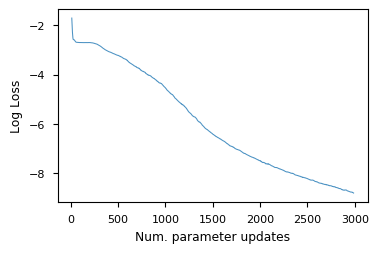

In [12]:
mk_dir("_data")

with plt.style.context('seaborn-paper', after_reset=True):

    fig, ax1 = plt.subplots(1, 1, figsize=(4, 2.5))

    window = 25
    avg_mask = np.ones(window) / window

    ax1.plot(np.convolve(range(len(losses)), avg_mask, 'valid'),
             np.convolve(np.log(losses), avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
#     ax1.set_yscale("log")

    ax1.set_xlabel("Num. parameter updates")
    ax1.set_ylabel("Log Loss")
    
    fig_fname = "_data/training_loss"
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

In [13]:
torch.save(decoder.state_dict(), "decoder.pth")
torch.save(encoder.state_dict(), "encoder.pth")
rep_thetas = [rep.thetas for rep in lat_env.action_reps]
torch.save(rep_thetas, "representations.pth")
torch.save(optimizer_dec.state_dict(), "optimizer_dec.pth")
torch.save(optimizer_enc.state_dict(), 'optimizer_enc.pth')
torch.save(optimizer_rep.state_dict(), "optimizer_rep.pth")

## 4. Testing

Testing is easy too, we just play out an episode and see how well the reconstructed image agrees with the ground truth!

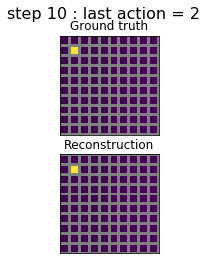

In [14]:
def plot_state(obs, ax, one_hot=True):
    if one_hot:
        obs=(obs == obs.max())
    ax.pcolormesh(obs.reshape(obs_env.dim, obs_env.dim), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = obs_env.action_space.sample().item()
        obs_x = obs_env.step(action)
        obs_z = lat_env.step(action)
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2, one_hot=False)
    
    fig_fname = "_data/testing_{}".format(i)
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

We will now have a look at the latent space, we will make a 2D projection of the 4D latent space for every possible frame (There are 25 for the 5x5 grid). Note that since we use random projections, in some cases the toric structure we find is more obvious than in others.

**1) Positions on the grid**

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


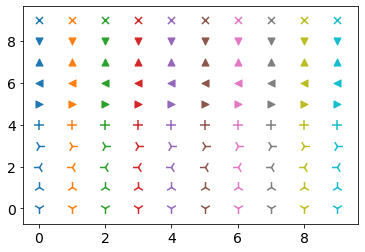

In [15]:
from sklearn.random_projection import GaussianRandomProjection
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')

#color=["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]
color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]

s=[120]*5+[50]*6

for i in range (100):
    ax.scatter(x=i//10,
                y=i%10,
   #             zs=latent_2d.transpose()[2][i],
                c=color[i//10], 
                s=s[i%10],
                marker=marks[i%10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("grid11.png", bbox_inches='tight')

**2) Positions in Latent Space**

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


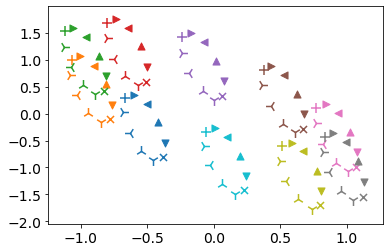

In [52]:
num_frames = sum(obs_env.observation_space.shape)

latent_points = []

for i in range(num_frames):
    frame = torch.zeros(num_frames)
    frame[i] = 1
    latent = encoder(frame)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

pca = GaussianRandomProjection(n_components=2)

latent_2d = pca.fit_transform(latent_map)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (100):
    ax.scatter(x=latent_2d.transpose()[0][i],
                y=latent_2d.transpose()[1][i],
             #   zs=latent_2d.transpose()[2][i],
                c=color[i//10], 
                s=s[i%10],
                marker=marks[i%10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()

plt.savefig("tore2d.png", bbox_inches='tight')

**3) Show Action representations**

tensor([[ 0.8901,  0.3568,  0.1511, -0.2401],
        [-0.2331,  0.8813, -0.3391,  0.2323],
        [-0.2926,  0.2925,  0.9069, -0.0794],
        [ 0.2605, -0.1020,  0.1991,  0.9392]], grad_fn=<MmBackward>)
tensor([[-0.1498,  0.6440, -0.7431,  0.1034],
        [ 0.6499, -0.2411, -0.2457,  0.6776],
        [-0.7370, -0.2417,  0.0269,  0.6306],
        [ 0.1096,  0.6846,  0.6219,  0.3640]], grad_fn=<MmBackward>)
tensor([[ 0.8898, -0.2330, -0.2928,  0.2612],
        [ 0.3569,  0.8816,  0.2909, -0.1035],
        [ 0.1511, -0.3369,  0.9072,  0.2015],
        [-0.2408,  0.2344, -0.0812,  0.9383]], grad_fn=<MmBackward>)
tensor([[-0.1508,  0.6487, -0.7388,  0.1030],
        [ 0.6458, -0.2363, -0.2439,  0.6838],
        [-0.7403, -0.2364,  0.0311,  0.6286],
        [ 0.1102,  0.6837,  0.6275,  0.3559]], grad_fn=<MmBackward>)
tensor([[ 0.9194,  0.0805,  0.2388,  0.3020],
        [-0.2028,  0.9276,  0.2730,  0.1544],
        [-0.0974, -0.2274,  0.9013, -0.3555],
        [-0.3226, -0.2852,  0.2367

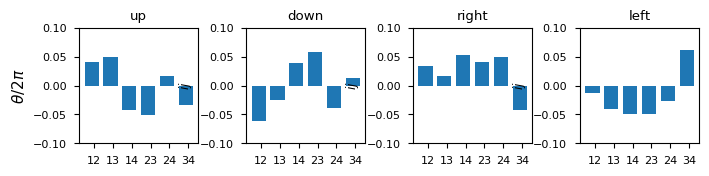

In [17]:
width=0.75

test_folder="_data"

for rep in lat_env.action_reps:
    print(rep.get_matrix())
    print(torch.matrix_power(rep.get_matrix(), 5))
rep_thetas = [rep.thetas.detach().numpy() for rep in lat_env.action_reps]

plt_lim = max( 0.1, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["up", "down", "right", "left"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, len(rep_thetas), figsize=(8, 1.5), gridspec_kw={"wspace":0.4})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","23","24","34"])
        axs[i].set_ylabel("$ij$")
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        
        axs[i].set_title(titles[i])
        
    axs[0].set_ylabel(r"$\theta / 2\pi$", fontsize=11)
    
    fig_fname = os.path.join(test_folder, "thetas")

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')